# Consistency of Atmospheric Moisture and Mass Budgets in ERA5

* find the way to compute global mass budget (dry air + moisure) on ERA5
* Apply this budget computation in AI weather prediction model as physcis-based constraints. 

In [1]:
import numpy as np
import xarray as xr

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ds_upper = xr.open_zarr('/glade/derecho/scratch/ksha/CREDIT_data/ERA5_pressure_lev/upper_air_test.zarr')
ds_surf = xr.open_zarr('/glade/derecho/scratch/ksha/CREDIT_data/ERA5_pressure_lev/surf_test.zarr')

In [4]:
GRAVITY = 9.80665

In [5]:
x = ds_surf['longitude']
y = ds_surf['latitude']
lon, lat = np.meshgrid(x, y)
level_p = 100*np.array(ds_upper['level'])

In [54]:
level_p # Pa or kg/m/s2

array([   100,    200,    300,    500,    700,   1000,   2000,   3000,
         5000,   7000,  10000,  12500,  15000,  17500,  20000,  22500,
        25000,  30000,  35000,  40000,  45000,  50000,  55000,  60000,
        65000,  70000,  75000,  77500,  80000,  82500,  85000,  87500,
        90000,  92500,  95000,  97500, 100000])

## Moisture budget

### The moisture budget

Reference
* https://journals.ametsoc.org/view/journals/clim/34/10/JCLI-D-20-0676.1.xml
* https://doi.org/10.1175/JCLI-D-13-00018.1

Equation
\begin{equation}
\mathbf{\nabla} \cdot \frac{1}{g} \int_{0}^{p_s}{\left(\mathbf{v}q\right)}dp = -\frac{1}{g}\frac{\partial}{\partial t}\int_{0}^{p_s}{q}dp - E - P
\end{equation}

* $g$: gravitational constant --- $\mathrm{m\cdot s^{-2}}$
* $p_s$: surface pressure --- $\mathrm{kg\cdot m^{-1}\cdot s^{-2}}$
* $q$: specific humidity --- $\mathrm{kg/kg}$
* $\mathbf{v}$: horizontal wind vector --- $\mathrm{m\cdot s^{-1}}$
* $E$ and $P$: evaporation and precipitation as flux densities. Positive from atmos to ground --- $\mathrm{m\cdot hour^{-1}}$ or $\mathrm{kg\cdot m^{-2}\cdot hour^{-1}}$

Notes:
* pressure level integrals are computed from `np.trapz`
* $\mathbf{\nabla}$ is computed from `np.gradient`
* Unit: flux densities $\mathrm{kg\cdot m^{−2}\cdot s^{−1}}$; hourly quantities are converted to per seconds

### the pressure level integral of specific humidity

\begin{equation}
\frac{1}{g}\frac{\partial}{\partial t}\int_{0}^{p_s}{q}dp
\end{equation}

numerical approach: `np.trapz(q_column, level_p)`

In [6]:
q = np.array(ds_upper['specific_humidity']) # kg/kg

# # alternative: use TCW directly
# TCWV = np.array(ds_surf['total_column_water_vapour'])
# diff_era5 = TCWV[1, ...] / 3600 - TCWV[0, ...] / 3600

In [8]:
TCW_q = np.empty((3,)+lon.shape) # kg/m/s2

for i_time in range(3):
    for ix in range(lon.shape[0]):
        for iy in range(lon.shape[1]):
            q_column = q[i_time, :, ix, iy]
            TCW_q[i_time, ix, iy] = np.trapz(q_column, level_p)
            
TCW_q = TCW_q/GRAVITY # kg/m2/s

In [9]:
# TCW time diff 
TCW_test = TCW_q / 3600 #  convert to per sec
d_TCW = TCW_test[1, ...] - TCW_test[0, ...]

Text(0.5, 1.0, 'The hourly diff of q integral [kg/m2/s]')

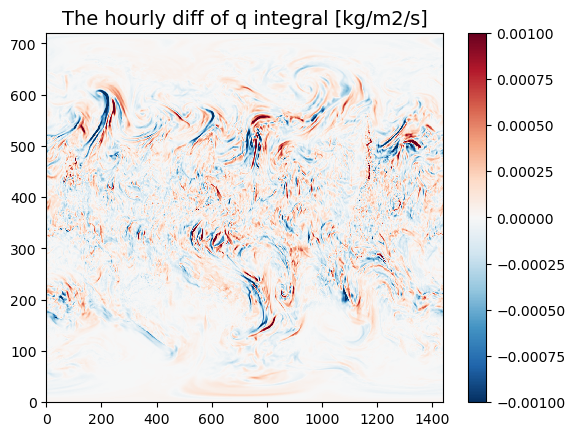

In [43]:
plt.pcolormesh(d_TCW, vmin=-1e-3, vmax=1e-3, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('The hourly diff of q integral [kg/m2/s]', fontsize=14)

### Evaporation and precipitation

In [33]:
precip = np.array(ds_surf['total_precipitation'])
evapor = np.array(ds_surf['evaporation'])

p_flux = precip / 3600 # m/s --> kg/m^2/s
e_flux = evapor / 3600

net_flux = -e_flux - p_flux

Text(0.5, 1.0, 'Net precip and evapor flux [kg/m2/s]')

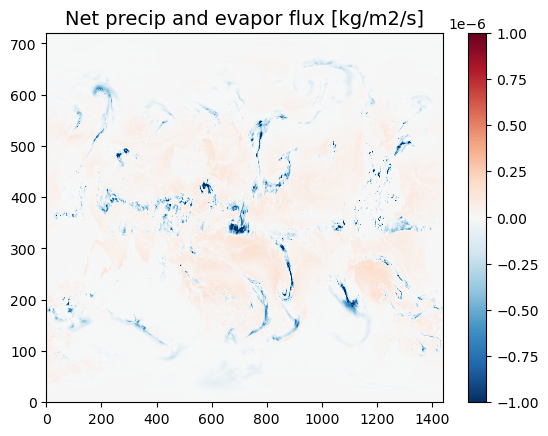

In [36]:
plt.pcolormesh(net_flux[0, ...], vmin=-1e-6, vmax=1e-6, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('Net precip and evapor flux [kg/m2/s]', fontsize=14)

### The divergence of vertically integrated moisture flux

\begin{equation}
\mathbf{\nabla} \cdot \frac{1}{g} \int_{0}^{p_s}{\left(\mathbf{v}q\right)}dp
\end{equation}

numerical approach: `np.gradient(axis=0)`, `np.gradient(axis=1)`

In [65]:
def compute_divergence(u, v, lat, lon):
    # Convert latitude and longitude from degrees to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Earth's radius in meters
    R = 6371000  # m
    
    # dlat, dlon [m]
    ## (lat, lon)
    dy = R * np.gradient(lat_rad, axis=0)  # derivative wrt latitude
    dx = R * np.cos(lat_rad) * np.gradient(lon_rad, axis=1)  # derivative wrt longitude
    
    # Compute the divergence
    ## (time, lat, lon)
    dvdy = np.gradient(v, axis=1) / dy
    dudx = np.gradient(u, axis=2) / dx
    
    # Total divergence
    divergence = dudx + dvdy
    
    return divergence

In [66]:
u = np.array(ds_upper['u_component_of_wind']) # m/s
v = np.array(ds_upper['v_component_of_wind'])

In [67]:
Fx = u*q # m/s
Fy = v*q

In [68]:
Fx_int = np.empty((3,)+lon.shape) # kg / s^3
Fy_int = np.empty((3,)+lon.shape)

for i_time in range(3):
    for ix in range(lon.shape[0]):
        for iy in range(lon.shape[1]):
            Fx_column = Fx[i_time, :, ix, iy]
            Fx_int[i_time, ix, iy] = np.trapz(Fx_column, level_p)
            
            Fy_column = Fy[i_time, :, ix, iy]
            Fy_int[i_time, ix, iy] = np.trapz(Fy_column, level_p)

Fx_int = Fx_int / GRAVITY # kg/m/s
Fy_int = Fy_int / GRAVITY

In [69]:
div_term = compute_divergence(Fx_int, Fy_int, lat, lon) # kg/m2/s

Text(0.5, 1.0, 'The divergence of moisture flux integral [kg/m2/s]')

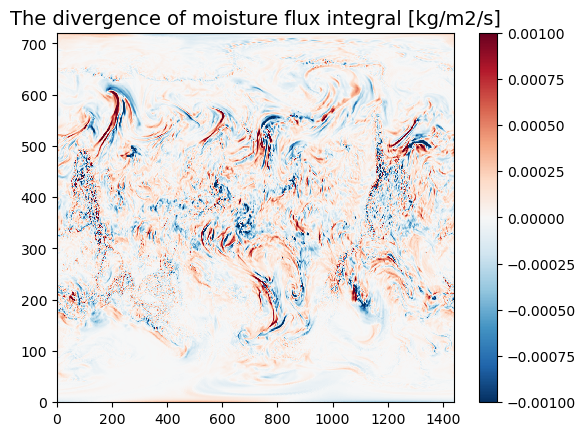

In [70]:
plt.pcolormesh(div_term[0, ...], vmin=-1e-3, vmax=1e-3, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('The divergence of moisture flux integral [kg/m2/s]', fontsize=14)

### budget residuals

In [75]:
# pick t = 1
left_group = -div_term[1, ...] -e_flux[1, ...] - p_flux[1, ...]

# d(t=1) - d(t=0)
right_group = TCW_test[1, ...] - TCW_test[0, ...]

Text(0.5, 1.0, 'E - P - transport vs. dTCW')

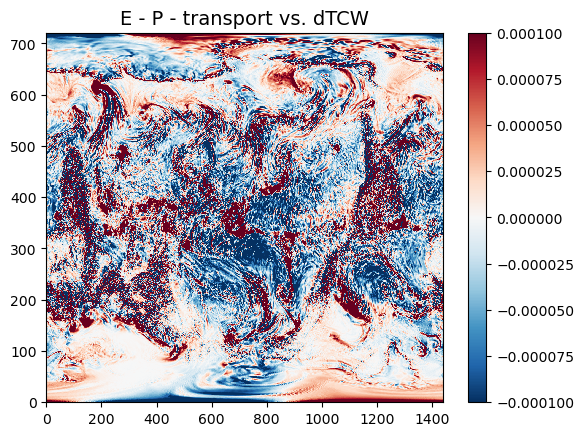

In [76]:
plt.pcolormesh(left_group-right_group, vmin=-1e-4, vmax=1e-4, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('E - P - transport vs. dTCW', fontsize=14)

Text(0.5, 1.0, 'E - P - transport')

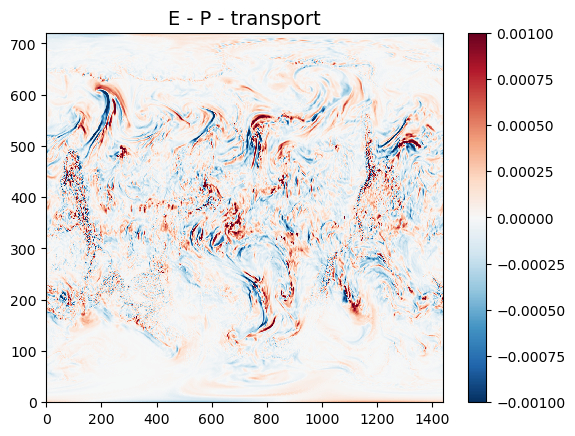

In [77]:
plt.pcolormesh(left_group, vmin=-1e-3, vmax=1e-3, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('E - P - transport', fontsize=14)

Text(0.5, 1.0, 'dTCW')

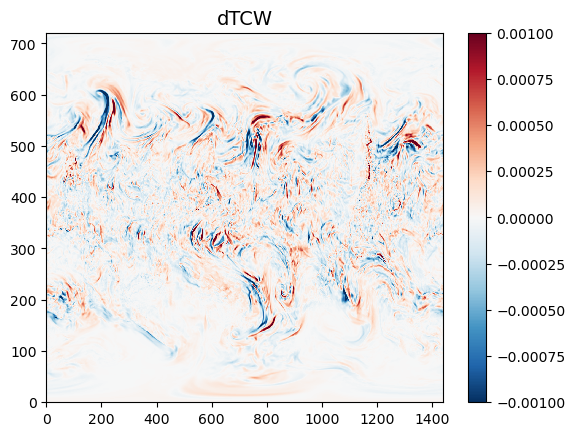

In [78]:
plt.pcolormesh(right_group, vmin=-1e-3, vmax=1e-3, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('dTCW', fontsize=14)

## Pytorch version (x)

In [52]:
lon_tensor = torch.from_numpy(lon)
lat_tensor = torch.from_numpy(lat)
level_tensor = torch.from_numpy(level_p)

In [22]:
q_tensor = torch.from_numpy(np.array(q))
TWC_tensor = torch.from_numpy(np.array(TWC ))